# DOJ asylum decisions by nationality
### [Output Dataset(s)](../data/extracted_data/doj)

## Purpose 

EOIR has published [data](https://www.justice.gov/eoir/page/file/1107366/download) on asylum decision rates by nationality since around 2019 as part of their switch from releasing annual statistical yearbooks to releasing regularly updated individual data sets (“workload and adjudication statistics”).

Every time they update this data they overwrite the previous year’s data. 

## Approach

To get all versions of this data we can leverage python and the Wayback Machine to collect previous versions of the [PDF]( https://web.archive.org/web/*/https://www.justice.gov/eoir/page/file/1107366/download). 

We don't have to do this manually though - we can use a python library to find the different versions and download them.

We can then extract the data from the PDFs.

In [1]:
import requests
import pprint

import numpy as np
import pandas as pd
import waybackpy

from datetime import timedelta
from pathlib import Path

pp = pprint.PrettyPrinter(indent=4)

## Download PDFs From Wayback Machine

**Functions**

In [4]:
def download_pdf(url, name, output_directory):
    """
    Function to download a single pdf file from a provided link.

    Parameters:
      url: URL of the file you want to download
      name: Label you want to apply to the file

      output_folder: Folder path to savae file

    Returns:
      Saves the file to the output directory, function itself returns nothing.

    Example:
      download_pdf(
        'https://www.justice.gov/eoir/page/file/1107366/download',
        'eoir_data',
        './'
      )
    """
    output_folder = Path(output_directory)
    response = requests.get(url)
    if response.status_code == 200:
        # Write content in pdf file
        outpath = output_directory / f"{name}.pdf"
        pdf = open(str(outpath), "wb")
        pdf.write(response.content)
        pdf.close()
        print("File ", f"{name}.pdf", " downloaded")
    else:
        print("File ", f"{name}.pdf", " not found.")

### Using a Wayback Machine Python Library to Get Wayback Machine URLs

We pick the url of a file / page we are insterested in, here it is [EOIR Adjudication Stats](https://www.justice.gov/eoir/page/file/1107366/download)

We also set up something called a user agent. A user agent is a grouping of information you pass to a website that suggests you are an actual person, vs. a machine (python code), using a web browser to access that website. 

Some websites block automated access so you need to provide this info.

We then pass the url and the user agent info to the waybackpy library and create an instance of the waybackpy tool for accessing the EOIR data.

In [5]:
url = "https://www.justice.gov/eoir/page/file/1107366/download"

user_agent = "Mozilla/5.0 (Windows NT 5.1; rv:40.0) Gecko/20100101 Firefox/40.0"
wayback = waybackpy.Url(url, user_agent)

The waybackpy package allows us to find the oldest date and newest date a url was archived. We can also search for the date that is nearest a date that we provide. 

So what we will do is:
1. get the oldest date
2. then search every 90 days from the oldest date till we reach the newest date for the archive date 
3. save each of those dates and their corresponding wayback urls 
4. make sure we only get unique wayback urls (note this does not guarantee that the data archived is unique) 
5. then download each of the pdf files associated with those wayback archive urls. 

In [6]:
# Python Dictionary to store the Wayback urls
wb_archive_urls = {}

# Get the oldest archive date and URL
oldest = wayback.oldest()
oldest_date = oldest.timestamp
print("Oldest Archive Date", oldest_date)
wb_archive_urls[oldest_date] = oldest.archive_url

# Get the newest archive date and URL
newest = wayback.newest()
newest_date = newest.timestamp
print("Newest Archive Date", newest_date)
wb_archive_urls[newest_date] = newest.archive_url

Oldest Archive Date 2019-03-06 01:21:00
Newest Archive Date 2021-09-28 21:11:24


In [9]:
# Take the oldest date and set a variable called `search_date` to it
# then keep adding 90 days to the search date and see if the wayback
# machine has a new archive date near that search date
# stop when we reach the newest date
search_date = oldest_date
retrieved_dates = [oldest_date, newest_date]

while search_date < newest_date:
    search_date += timedelta(days=90)
    check_for_next = wayback.near(year=search_date.year, month=search_date.month)
    if check_for_next.timestamp in retrieved_dates:
        continue
    else:
        retrieved_dates.append(check_for_next.timestamp)
        wb_archive_urls[check_for_next.timestamp] = check_for_next.archive_url

pp.pprint(sorted(retrieved_dates))

[   datetime.datetime(2019, 3, 6, 1, 21),
    datetime.datetime(2019, 10, 3, 1, 7, 56),
    datetime.datetime(2020, 1, 14, 2, 26, 25),
    datetime.datetime(2020, 2, 1, 3, 59, 31),
    datetime.datetime(2020, 5, 19, 1, 19, 51),
    datetime.datetime(2020, 8, 1, 19, 34, 30),
    datetime.datetime(2020, 12, 20, 19, 26, 12),
    datetime.datetime(2021, 3, 2, 13, 53, 24),
    datetime.datetime(2021, 5, 17, 22, 57, 49),
    datetime.datetime(2021, 9, 28, 21, 11, 24)]


The dates above are year, month, day, hour, minute. So we can see that we have grabbed urls for dates ranging from 2019-03-06 - 2021-09-28 . This date range will shift depending on when the code is run.

Below we print our dictionary of wayback urls, where the keys are the dates. 

In [10]:
pp.pprint(wb_archive_urls)

{   datetime.datetime(2019, 3, 6, 1, 21): 'https://web.archive.org/web/20190306012100/https://www.justice.gov/eoir/page/file/1107366/download',
    datetime.datetime(2019, 10, 3, 1, 7, 56): 'https://web.archive.org/web/20191003010756/https://www.justice.gov/eoir/page/file/1107366/download',
    datetime.datetime(2020, 1, 14, 2, 26, 25): 'https://web.archive.org/web/20200114022625/https://www.justice.gov/eoir/page/file/1107366/download',
    datetime.datetime(2020, 2, 1, 3, 59, 31): 'https://web.archive.org/web/20200201035931/https://www.justice.gov/eoir/page/file/1107366/download',
    datetime.datetime(2020, 5, 19, 1, 19, 51): 'https://web.archive.org/web/20200519011951/https://www.justice.gov/eoir/page/file/1107366/download',
    datetime.datetime(2020, 8, 1, 19, 34, 30): 'https://web.archive.org/web/20200801193430/https://www.justice.gov/eoir/page/file/1107366/download',
    datetime.datetime(2020, 12, 20, 19, 26, 12): 'https://web.archive.org/web/20201220192612/https://www.justice.

In [11]:
wb_archive_urls

{datetime.datetime(2019, 3, 6, 1, 21): 'https://web.archive.org/web/20190306012100/https://www.justice.gov/eoir/page/file/1107366/download',
 datetime.datetime(2021, 9, 28, 21, 11, 24): 'https://web.archive.org/web/20210928211124/https://www.justice.gov/eoir/page/file/1107366/download',
 datetime.datetime(2019, 10, 3, 1, 7, 56): 'https://web.archive.org/web/20191003010756/https://www.justice.gov/eoir/page/file/1107366/download',
 datetime.datetime(2020, 1, 14, 2, 26, 25): 'https://web.archive.org/web/20200114022625/https://www.justice.gov/eoir/page/file/1107366/download',
 datetime.datetime(2020, 2, 1, 3, 59, 31): 'https://web.archive.org/web/20200201035931/https://www.justice.gov/eoir/page/file/1107366/download',
 datetime.datetime(2020, 5, 19, 1, 19, 51): 'https://web.archive.org/web/20200519011951/https://www.justice.gov/eoir/page/file/1107366/download',
 datetime.datetime(2020, 8, 1, 19, 34, 30): 'https://web.archive.org/web/20200801193430/https://www.justice.gov/eoir/page/file/110

### Now Download the PDFs from the Wayback Machine

In [12]:
# We will save the pdfs in the export directory below
export_directory = Path("../data/raw_source_files/justice.gov/")

for link in wb_archive_urls:
    url = wb_archive_urls[link]
    download_pdf(url, f"eoir_adjudication_stats_{str(link)}", export_directory)

File  eoir_adjudication_stats_2019-03-06 01:21:00.pdf  downloaded
File  eoir_adjudication_stats_2021-09-28 21:11:24.pdf  downloaded
File  eoir_adjudication_stats_2019-10-03 01:07:56.pdf  downloaded
File  eoir_adjudication_stats_2020-01-14 02:26:25.pdf  downloaded
File  eoir_adjudication_stats_2020-02-01 03:59:31.pdf  downloaded
File  eoir_adjudication_stats_2020-05-19 01:19:51.pdf  downloaded
File  eoir_adjudication_stats_2020-08-01 19:34:30.pdf  downloaded
File  eoir_adjudication_stats_2020-12-20 19:26:12.pdf  downloaded
File  eoir_adjudication_stats_2021-03-02 13:53:24.pdf  downloaded
File  eoir_adjudication_stats_2021-05-17 22:57:49.pdf  downloaded


We can list files in a directory with the ls command - below we can see that we have successfully downloaded all of the pdfs

In [13]:
ls ../data/raw_source_files/justice.gov/

eoir_adjudication_stats_2019-03-06 01:21:00.pdf
eoir_adjudication_stats_2019-10-03 01:07:56.pdf
eoir_adjudication_stats_2019-11-13 02:08:38.pdf
eoir_adjudication_stats_2020-01-14 02:26:25.pdf
eoir_adjudication_stats_2020-02-01 03:59:31.pdf
eoir_adjudication_stats_2020-05-19 01:19:51.pdf
eoir_adjudication_stats_2020-08-01 19:34:30.pdf
eoir_adjudication_stats_2020-09-28 23:53:59.pdf
eoir_adjudication_stats_2020-12-20 19:26:12.pdf
eoir_adjudication_stats_2021-01-19 23:28:15.pdf
eoir_adjudication_stats_2021-03-02 13:53:24.pdf
eoir_adjudication_stats_2021-05-17 22:57:49.pdf
eoir_adjudication_stats_2021-09-28 21:11:24.pdf


**Note**: Now these PDFs were not updated very frequently. The only place in the PDF where it indicates what term this data covers is the in the #1 Footnote. Given that we don't have a large number of PDFs its probably faster to just go through and see which are unique, what fiscal period they cover and when they were last updated. 

This is our approach below. This process can be automated using code, but isn't something we currently support.

eoir_adjudication_stats_2019-03-06 01:21:00.pdf --> Asylum rates for Fiscal Year 2018. Data generated on October 24, 2018 <br>
eoir_adjudication_stats_2019-10-03 01:07:56.pdf --> Same as above <br>
eoir_adjudication_stats_2019-11-13 02:08:38.pdf --> Asylum rates for Fiscal Year 2019, Data generated on October 23, 2019<br>
eoir_adjudication_stats_2020-02-01 03:59:31.pdf --> Same as above <br>
eoir_adjudication_stats_2020-05-19 01:19:51.pdf --> Same as above <br>
eoir_adjudication_stats_2020-08-01 19:34:30.pdf --> Asylum rates for Fiscal Year 2020, Data generated on July 14, 2020 <br>
eoir_adjudication_stats_2020-09-28 23:53:59.pdf --> Same as above <br>
eoir_adjudication_stats_2021-01-19 23:28:15.pdf -->  Fiscal Year 2021,  Data generated on January 7, 2020<br>
eoir_adjudication_stats_2021-05-17 22:57:49.pdf --> Fiscal Year 2021, Data generated on April 19, 2021<br>
eoir_adjudication_stats_2021-09-28 21:11:24.pdf -->  Fiscal Year 2021, Data generated on July 8, 2021 <br>

So our unique dataset are:


In [16]:
uniq_pdfs = {
    "eoir_adjudication_stats_2019-03-06 01:21:00.pdf": ["FS18", "10/2018"],
    "eoir_adjudication_stats_2019-11-13 02:08:38.pdf": ["FS19", "10/2019"],
    "eoir_adjudication_stats_2020-08-01 19:34:30.pdf": ["FS20", "07/2020"],
    "eoir_adjudication_stats_2021-01-19 23:28:15.pdf": ["FS21", "01/2021"],
    "eoir_adjudication_stats_2021-05-17 22:57:49.pdf": ["FS21", "04/2021"],
    "eoir_adjudication_stats_2021-09-28 21:11:24.pdf": ["FS21", "07/2021"],
}

the structure is the pdf filename as the key and then the values are the Fiscal Year followed by the month the data was generated

## Extracting Structured Data from the PDFs 

### First Let's Try 1 PDF

In [17]:
from PyPDF2 import PdfFileReader
from tabula.io import read_pdf

**First let's extract one page to see if the tabula library is successful**

In [18]:
extract_test = read_pdf(
    export_directory / "eoir_adjudication_stats_2019-03-06 01:21:00.pdf",
    pages=1,
    lattice=True,
    pandas_options={"header": None},  # none because some have headers and some dont
)[0]

Below we see the single extracted page - by comparing to page 1 of that actual pdf we can see that overall the results look great. 


In [19]:
extract_test.head(20)

,0,1,2,3,4,5,6,7,8,9
0,Admin\rDenialAdmin\rNationalityGrants2\rGrant ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Nationality,Grants2,Grant Rate,Denials,Denial\rRate,Other3,Other Rate,Admin\rClosure4,Admin\rClosure\rRate,Total
2,AFGHANISTAN,28,*,19,*,21,*,*,*,*
3,ALBANIA,181,62.41%,55,18.97%,49,16.90%,5,1.72%,290
4,ALGERIA,*,*,*,*,*,*,*,*,*
5,ANGOLA,19,*,29,*,10,*,*,*,*
6,ANTIGUA AND\rBARBUDA,*,*,*,*,*,*,*,*,*
7,ARGENTINA,*,*,8,*,16,*,*,*,*
8,ARMENIA,60,*,39,*,43,*,*,*,*
9,AUSTRALIA,*,*,*,*,*,*,*,*,*



The only issue is that the headers are pretty messed up. If we check a couple of other pages (try putting in 2,3,4) for the `pages=1` value. We see this is a consistent issue and actually we can just drop the first 2 rows.

So we will write that into our `get_table_data` function.

In [23]:
def get_table_data(path):
    """
    Parameters:
      path: path to specific PDF file to extract data from

    Returns:
      Pandas dataframe of structured (tabular) data extracted from the PDF
      path provided.

    Example:
      get_table_data( 'eoir_adjudication_stats_2019-03-06 01:21:00.pdf' )

    """
    # Read the pdf to get basic info on it
    pdf = PdfFileReader(path)

    # Data Holders
    full_table = pd.DataFrame()  # Will hold the combined data

    # Processing PDF - we start with the first page (start) and go to the last page (stop)
    start = 1
    stop = pdf.getNumPages() + 1
    for i in range(start, stop):
        # Extract data from the specific PDF page using Tabula
        df = read_pdf(
            path,
            pages=f"{i}",
            lattice=True,
            pandas_options={
                "header": None
            },  # none because some have headers and some dont
        )[0]
        if len(df.columns) == 10:
            df.columns = [
                "nationality",
                "grants",
                "grant rate",
                "denials",
                "denial rate",
                "other",
                "other rate",
                "admin closure",
                "admin closure rate",
                "total",
            ]
        elif len(df.columns) == 8:
            df.columns = [
                "nationality",
                "grants",
                "grant rate",
                "denials",
                "denial rate",
                "other",
                "other rate",
                "total",
            ]
        else:
            raise AssertionError(
                "Something is wrong with column lengths check the pdf file manually"
            )
        # Here we drop the first N rows, the weird headers.
        df = df.loc[
            df[df["nationality"].str.lower().str.contains("nationality")].index.max()
            + 1 :,
            :,
        ]

        df = df[~df["nationality"].str.lower().str.contains("asylum rates for fiscal")]
        # Append this page of data to the full table
        full_table = full_table.append(df)

    return full_table

Let's define the columns that are in the source table

In [24]:
pdf_cols = [
    "nationality",
    "grants",
    "grant rate",
    "denials",
    "denial rate",
    "other",
    "other rate",
    "admin closure",
    "admin closure rate",
    "total",
]

Now grab the full pdf

In [25]:
test = get_table_data(
    str(export_directory / "eoir_adjudication_stats_2019-03-06 01:21:00.pdf")
)

In [26]:
test.head()

,nationality,grants,grant rate,denials,denial rate,other,other rate,admin closure,admin closure rate,total
2,AFGHANISTAN,28,*,19,*,21,*,*,*,*
3,ALBANIA,181,62.41%,55,18.97%,49,16.90%,5,1.72%,290
4,ALGERIA,*,*,*,*,*,*,*,*,*
5,ANGOLA,19,*,29,*,10,*,*,*,*
6,ANTIGUA AND\rBARBUDA,*,*,*,*,*,*,*,*,*


Looks pretty great, only issue is that we have asterisks in the data, and I bet we have some "," separators in the dataset as well. This is a problem because it means we can't treat those columns as having real numbers in them, making it impossible to aggregate. 

**[OPTIONAL]  Cleaning the data** 

This is optional because you could likley do this in excel instead

In [27]:
# Clean the asterisks - replace all of them with NULL or nan(not a number)
test = test.replace("*", np.nan)

# Iterate over the columns
# convert the value to type string, then replace any "," with "",
# and convert the new value to type float.
numerics = ["grants", "denials", "other", "admin closure", "total"]
for col in numerics:
    test[col] = test[col].astype(str).str.replace(",", "").astype(float)

In [28]:
test.head()

,nationality,grants,grant rate,denials,denial rate,other,other rate,admin closure,admin closure rate,total
2,AFGHANISTAN,28.0,NaN,19.0,NaN,21.0,NaN,NaN,NaN,NaN
3,ALBANIA,181.0,62.41%,55.0,18.97%,49.0,16.90%,5.0,1.72%,290.0
4,ALGERIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ANGOLA,19.0,NaN,29.0,NaN,10.0,NaN,NaN,NaN,NaN
6,ANTIGUA AND\rBARBUDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Second Let's Get All PDFs

Earlier we identifed the unique pdfs to grab and saved some info about them in the `uniq_pdfs` dictionary

In [29]:
uniq_pdfs

{'eoir_adjudication_stats_2019-03-06 01:21:00.pdf': ['FS18', '10/2018'],
 'eoir_adjudication_stats_2019-11-13 02:08:38.pdf': ['FS19', '10/2019'],
 'eoir_adjudication_stats_2020-08-01 19:34:30.pdf': ['FS20', '07/2020'],
 'eoir_adjudication_stats_2021-01-19 23:28:15.pdf': ['FS21', '01/2021'],
 'eoir_adjudication_stats_2021-05-17 22:57:49.pdf': ['FS21', '04/2021'],
 'eoir_adjudication_stats_2021-09-28 21:11:24.pdf': ['FS21', '07/2021']}

In [30]:
tables = []
for pdf in uniq_pdfs:
    print(pdf)
    table = get_table_data(str(export_directory / pdf))
    table["fiscal_year"] = uniq_pdfs[pdf][0]
    table["generated_my"] = uniq_pdfs[pdf][1]
    table["pdf_file"] = pdf
    tables.append(table)

eoir_adjudication_stats_2019-03-06 01:21:00.pdf
eoir_adjudication_stats_2019-11-13 02:08:38.pdf
eoir_adjudication_stats_2020-08-01 19:34:30.pdf
eoir_adjudication_stats_2021-01-19 23:28:15.pdf
eoir_adjudication_stats_2021-05-17 22:57:49.pdf
eoir_adjudication_stats_2021-09-28 21:11:24.pdf


In [31]:
all_data_df = pd.DataFrame()
for table in tables:
    all_data_df = all_data_df.append(table)
all_data_df = all_data_df.reset_index(drop=True)

In [32]:
all_data_df

,nationality,grants,grant rate,denials,denial rate,other,other rate,admin closure,admin closure rate,total,fiscal_year,generated_my,pdf_file
0,AFGHANISTAN,28,*,19,*,21,*,*,*,*,FS18,10/2018,eoir_adjudication_stats_2019-03-06 01:21:00.pdf
1,ALBANIA,181,62.41%,55,18.97%,49,16.90%,5,1.72%,290,FS18,10/2018,eoir_adjudication_stats_2019-03-06 01:21:00.pdf
2,ALGERIA,*,*,*,*,*,*,*,*,*,FS18,10/2018,eoir_adjudication_stats_2019-03-06 01:21:00.pdf
3,ANGOLA,19,*,29,*,10,*,*,*,*,FS18,10/2018,eoir_adjudication_stats_2019-03-06 01:21:00.pdf
4,ANTIGUA AND\rBARBUDA,*,*,*,*,*,*,*,*,*,FS18,10/2018,eoir_adjudication_stats_2019-03-06 01:21:00.pdf
...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,VENEZUELA,319,51%,150,24%,160,25%,NaN,NaN,629,FS21,07/2021,eoir_adjudication_stats_2021-09-28 21:11:24.pdf
855,VIETNAM,37,61%,15,25%,9,15%,NaN,NaN,61,FS21,07/2021,eoir_adjudication_stats_2021-09-28 21:11:24.pdf
856,YEMEN,7,29%,10,42%,7,29%,NaN,NaN,24,FS21,07/2021,eoir_adjudication_stats_2021-09-28 21:11:24.pdf
857,ZAMBIA,*,*,*,*,*,*,NaN,NaN,*,FS21,07/2021,eoir_adjudication_stats_2021-09-28 21:11:24.pdf


In [34]:
# Clean the asterisks - replace all of them with NULL or nan(not a number)
all_data_df = all_data_df.replace("*", np.nan)

# Convert the numeric columns to a float - iterate over the columns,
# convert the value to type string, then replace any "," with "",
# and convert the new value to type float.
numerics = ["grants", "denials", "other", "admin closure", "total"]
for col in numerics:
    all_data_df[col] = all_data_df[col].astype(str).str.replace(",", "").astype(float)

In [35]:
all_data_df.generated_my = pd.to_datetime(all_data_df.generated_my)

In [36]:
all_data_df

,nationality,grants,grant rate,denials,denial rate,other,other rate,admin closure,admin closure rate,total,fiscal_year,generated_my,pdf_file
0,AFGHANISTAN,28.0,NaN,19.0,NaN,21.0,NaN,NaN,NaN,NaN,FS18,2018-10-01,eoir_adjudication_stats_2019-03-06 01:21:00.pdf
1,ALBANIA,181.0,62.41%,55.0,18.97%,49.0,16.90%,5.0,1.72%,290.0,FS18,2018-10-01,eoir_adjudication_stats_2019-03-06 01:21:00.pdf
2,ALGERIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FS18,2018-10-01,eoir_adjudication_stats_2019-03-06 01:21:00.pdf
3,ANGOLA,19.0,NaN,29.0,NaN,10.0,NaN,NaN,NaN,NaN,FS18,2018-10-01,eoir_adjudication_stats_2019-03-06 01:21:00.pdf
4,ANTIGUA AND\rBARBUDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FS18,2018-10-01,eoir_adjudication_stats_2019-03-06 01:21:00.pdf
...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,VENEZUELA,319.0,51%,150.0,24%,160.0,25%,NaN,NaN,629.0,FS21,2021-07-01,eoir_adjudication_stats_2021-09-28 21:11:24.pdf
855,VIETNAM,37.0,61%,15.0,25%,9.0,15%,NaN,NaN,61.0,FS21,2021-07-01,eoir_adjudication_stats_2021-09-28 21:11:24.pdf
856,YEMEN,7.0,29%,10.0,42%,7.0,29%,NaN,NaN,24.0,FS21,2021-07-01,eoir_adjudication_stats_2021-09-28 21:11:24.pdf
857,ZAMBIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FS21,2021-07-01,eoir_adjudication_stats_2021-09-28 21:11:24.pdf


## A quick chart just for reference

<AxesSubplot:xlabel='generated_my'>

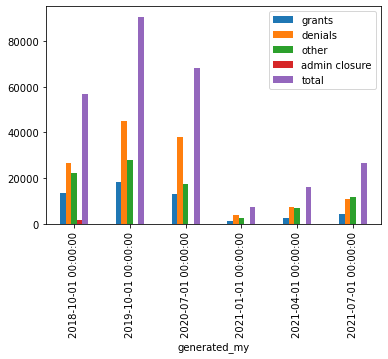

In [38]:
all_data_df.groupby(["generated_my"])[numerics].sum().sort_index().plot(kind="bar")

In [ ]:
all_data_df.to_csv("../data/extracted_data/doj_eoir_asylym_decisions.csv")

# End